In [11]:
from functools import lru_cache
from numpy import cos, sin
from tqdm import tqdm
import numpy as np
import random
import glob
import cv2
import os

In [12]:
focal_length = [2.5, 2.5]  # 焦距，越小越圆
xi_ = [4.5, 7.5]  # ξ,越大图越小且越圆
radial_param = [-2.0, -2.0, -2.0]  # 径向畸变参数
tangential_param = [0.0, 0.0]  # 切向畸变参数
gamma = None  # γ
u0, v0 = 1, 1  # 焦点
s = 0.0  # 斜度
r = 1.0  # 长宽比
projection_matrix = None
distance = None  # 初始时图像平面到单位球心的距离
# 旋转矩阵参数
alpha_ = [-0.2, 0.2]  # 正：向下旋转 负：向上旋转 [-0.3,0.3]
beta_ = [-0.2, 0.2]  # 正：向左旋转 负：向右旋转 [-0.3,0.3]
theta_ = [-0.1, 0.1]  # 平面旋转 [-0.1,0.1]
x_trans = 0
y_trans = 0
z_trans = 0

x_shift_ = [-50, 50]  # x方向偏移量
y_shift_ = [-50, 50]  # y方向偏移量

In [13]:
# 生成鱼眼图像
def generate(img):
    global gamma, projection_matrix, distance
    height, width = img.shape[:2]
    # img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    out_img = np.zeros(img.shape)
    # 以图像中心为原点，建立坐标矩阵
    center_x, center_y = width // 2, height // 2
    cord_x, cord_y = np.meshgrid(np.arange(start = -center_x, stop = center_x),
                                 np.arange(start = -center_y, stop = center_y))
    cord = np.dstack((cord_x, cord_y)).astype(np.float64)  # (256,256,2)
    cord = np.insert(cord, 2, 1, axis = 2)  # 插入z坐标值（单位球面），(256,256,3)
    
    alpha = random.uniform(alpha_[0], alpha_[1])
    beta = random.uniform(beta_[0], beta_[1])
    theta = random.uniform(theta_[0], theta_[1])
    gamma = random.uniform(focal_length[0], focal_length[1])
    distance = random.uniform(focal_length[0], focal_length[1]) * width / 12  # 控制畸变程度关键变量
    xi = random.uniform(xi_[0], xi_[1])
    x_shift = random.uniform(x_shift_[0], x_shift_[1])
    y_shift = random.uniform(y_shift_[0], y_shift_[1])
    projection_matrix = np.array([[gamma, gamma * s, u0], [0, gamma * r, v0], [0, 0, 1]]).astype(np.float64)
    rotate_matrix = np.array([[cos(beta) * cos(theta), cos(beta) * sin(theta), -sin(beta), x_trans],
                              [-cos(alpha) * sin(theta) + sin(alpha) * sin(beta) * cos(theta),
                               cos(alpha) * cos(theta) + sin(alpha) * sin(beta) * sin(theta), sin(alpha) * cos(beta),
                               y_trans], [sin(alpha) * sin(theta) + cos(alpha) * sin(beta) * cos(theta),
                                          -sin(alpha) * cos(theta) + cos(alpha) * sin(beta) * sin(theta),
                                          cos(alpha) * cos(beta), z_trans], [0, 0, 0, 1]])
    
    # 返回(x,y)投影后的坐标
    @lru_cache(maxsize = 1024, typed = False)
    def get_projection(i, j):
        cord_ij = cord[i][j]
        x, y = cord_ij[:2]
        x, y = float(x), float(y)
        x, y = x + x_shift, y + y_shift
        z = distance
        # formula(1)
        mod = np.sqrt(x * x + y * y + z * z)  # x,y归一化
        x, y, z = x / mod, y / mod, z / mod
        x, y, z = np.matmul(rotate_matrix, np.array([x, y, z, 1.0]).T)[:3]
        # x, y, z = float(x), float(y), float(z)
        
        x, y, z = x / (z + xi), y / (z + xi), 1.0
        # formula(4),https://physics.stackexchange.com/questions/273464/what-is-the-tangential-distortion-of
        # -opencv-actually-tangential-to
        r2 = x * x + y * y
        k = radial_param
        p = tangential_param
        c = 1 + k[0] * r2 + k[1] * r2 ** 2 + k[2] * r2 ** 3
        new_x = x * c + 2 * p[0] * x * y + p[1] * (r2 + 2 * x * x)
        new_y = y * c + 2 * p[1] * x * y + p[0] * (r2 + 2 * y * y)
        cord_ij[0], cord_ij[1], cord_ij[2] = new_x, new_y, z
        cord_ij = np.matmul(projection_matrix, cord_ij)
        
        x, y = round(cord_ij[0] * center_x), round(cord_ij[1] * center_y)
        return y, x
    
    for i in tqdm(range(height), ncols = 120):
        for j in range(width):
            try:
                x, y = get_projection(i, j)
            except:
                break
            if 0 <= x < height and 0 <= y < width:
                # if np.all(out_img[y][x] == 0):  # 如果已经设置过了就不再设置了，防止图片卷起来
                out_img[x][y] = img[i][j]
    return crop(completion(out_img))


# 按照uv贴图的方式，计算每一块四个点的投影坐标，然后将这一块变形为投影后的四边形
# show:是否显示绘制过程
def generateUV(img, show = True):
    global gamma, projection_matrix, distance
    height, width = img.shape[:2]
    # img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    out_img = np.zeros(img.shape).astype(np.uint8)
    
    # 显示绘制过程
    show_img = img.copy()
    show_img = cv2.resize(show_img, (img.shape[1] // 2, img.shape[0] // 2))
    show_out_img = out_img.copy()
    show_out_img = cv2.resize(show_out_img, (img.shape[1] // 2, img.shape[0] // 2))
    
    # 以图像中心为原点，建立坐标矩阵
    center_x, center_y = width // 2, height // 2
    cord_x, cord_y = np.meshgrid(np.arange(start = -center_x, stop = center_x),
                                 np.arange(start = -center_y, stop = center_y))
    cord = np.dstack((cord_x, cord_y)).astype(np.float64)  # (256,256,2)
    cord = np.insert(cord, 2, 1, axis = 2)  # 插入z坐标值（单位球面），(256,256,3)
    
    # 投影参数
    alpha = random.uniform(alpha_[0], alpha_[1])
    beta = random.uniform(beta_[0], beta_[1])
    theta = random.uniform(theta_[0], theta_[1])
    gamma = random.uniform(focal_length[0], focal_length[1])
    distance = random.uniform(focal_length[0], focal_length[1]) * width / 12  # 控制畸变程度关键变量
    xi = random.uniform(xi_[0], xi_[1])
    x_shift = random.uniform(x_shift_[0], x_shift_[1])
    y_shift = random.uniform(y_shift_[0], y_shift_[1])
    projection_matrix = np.array([[gamma, gamma * s, u0], [0, gamma * r, v0], [0, 0, 1]]).astype(np.float64)
    rotate_matrix = np.array([[cos(beta) * cos(theta), cos(beta) * sin(theta), -sin(beta), x_trans],
                              [-cos(alpha) * sin(theta) + sin(alpha) * sin(beta) * cos(theta),
                               cos(alpha) * cos(theta) + sin(alpha) * sin(beta) * sin(theta), sin(alpha) * cos(beta),
                               y_trans], [sin(alpha) * sin(theta) + cos(alpha) * sin(beta) * cos(theta),
                                          -sin(alpha) * cos(theta) + cos(alpha) * sin(beta) * sin(theta),
                                          cos(alpha) * cos(beta), z_trans], [0, 0, 0, 1]])
    
    # 返回(x,y)投影后的坐标
    @lru_cache(maxsize = 1024, typed = False)
    def get_projection(i, j):
        cord_ij = cord[i][j].copy()
        x, y = cord_ij[:2]
        x, y = float(x), float(y)
        x, y = x + x_shift, y + y_shift
        z = distance
        # formula(1)
        mod = np.sqrt(x * x + y * y + z * z)  # x,y归一化
        x, y, z = x / mod, y / mod, z / mod
        x, y, z = np.matmul(rotate_matrix, np.array([x, y, z, 1.0]).T)[:3]
        # x, y, z = float(x), float(y), float(z)
        
        x, y, z = x / (z + xi), y / (z + xi), 1.0
        # formula(4),https://physics.stackexchange.com/questions/273464/what-is-the-tangential-distortion-of
        # -opencv-actually-tangential-to
        r2 = x * x + y * y
        k = radial_param
        p = tangential_param
        c = 1 + k[0] * r2 + k[1] * r2 ** 2 + k[2] * r2 ** 3
        new_x = x * c + 2 * p[0] * x * y + p[1] * (r2 + 2 * x * x)
        new_y = y * c + 2 * p[1] * x * y + p[0] * (r2 + 2 * y * y)
        cord_ij[0], cord_ij[1], cord_ij[2] = new_x, new_y, z
        cord_ij = np.matmul(projection_matrix, cord_ij)
        
        x, y = round(cord_ij[0] * center_x), round(cord_ij[1] * center_y)
        return [y, x]
    
    block_size = 64  # 每次进行投影变换的一块区域大小
    for i in tqdm(range(0, height, block_size), ncols = 120):
        for j in range(0, width, block_size):
            # 以当前点为左上角计算四个点[左上，左下，右下，右上]
            block = [[i, j], [i + block_size - 1, j], [i + block_size - 1, j + block_size - 1], [i, j + block_size - 1]]
            block_proj = [[0, 0], [0, 0], [0, 0], [0, 0]]  # 投影后坐标
            for k in range(4):
                block[k][0] = max(0, block[k][0])
                block[k][0] = min(height - 2, block[k][0])  # 解决莫名其妙的边界错误
                block[k][1] = max(0, block[k][1])
                block[k][1] = min(width - 2, block[k][1])
                block_proj[k] = get_projection(block[k][0], block[k][1])
            block = np.float32(block)
            block_proj = np.float32(block_proj)
            for _ in range(4):
                block_proj[_] = block_proj[_][::-1]  # 反转
                block[_] = block[_][::-1]
            proj_M = cv2.getPerspectiveTransform(block, block_proj)  # 计算投影变换矩阵:block_proj = proj_M * block
            
            # 分割出要变换的块
            # 如果是先截取要分割的块再投影变化则因为走样原因会出现黑边，因此要先投影整张图像在截取
            # block_img = np.zeros(img.shape).astype(img.dtype)
            # block_img[i:i + block_size, j:j + block_size, :] = img[i:i + block_size, j:j + block_size, :]
            block_img = img.copy()
            mask = np.zeros(img.shape[:2], np.uint8)
            cv2.drawContours(mask, [block_proj.astype(np.int32)], -1, 255, -1, cv2.LINE_AA)  # 生成切割部分的mask
            
            # 计算投影结果
            proj_out = cv2.warpPerspective(block_img, proj_M, (width, height), cv2.INTER_LINEAR)
            proj_out = cv2.bitwise_and(proj_out, proj_out, mask = mask) # 图像按位与运算
            alpha = proj_out.sum(axis = (2))  # 获取第三维的和，如果为0，说明该像素为背景像素
            out_img_alpha = alpha == 0
            proj_out_alpha = alpha != 0  # 设置投影后的图像alpha
            for c in range(3):
                out_img[:, :, c] *= out_img_alpha
                proj_out[:, :, c] *= proj_out_alpha
            out_img = cv2.addWeighted(out_img, 1, proj_out, 1, 0)  # 图像叠加
            
            # 显示绘制过程
            if show:
                cv2.polylines(show_out_img, [block_proj.astype(np.int32) // 2], True, (0, 0, 255), 1, cv2.LINE_AA)
                cv2.polylines(show_img, [block.astype(np.int32) // 2], True, (0, 255, 0), 1, cv2.LINE_AA)  # 反走样
                cv2.imshow("show_img", show_img)
                cv2.imshow("show_out_img", show_out_img)
                cv2.imshow("out_img", out_img)
                cv2.waitKey(1)
    
    return crop(out_img)


# 生成的图像因为精度原因有些缺省，就是图像中的黑点，即rgb为0，要将这些部分插值补全
def completion(img):
    # 8-bit, 16-bit unsigned or 32-bit float 1-channel and 8-bit 3-channel input/output images
    mask = np.zeros(img.shape[:2]).astype(np.uint8)
    img = img.astype(np.uint8)
    radius = 5
    for i in tqdm(range(img.shape[0]), ncols = 120):
        for j in range(img.shape[1]):
            if np.all(img[i][j] == 0):
                # 如果当前位置周围的像素都为0,则不填充
                i_l = 0 if (i - radius) < 0 else (i - radius)
                i_r = (img.shape[0] - 1) if (i + radius) >= img.shape[0] else (i + radius)
                j_l = 0 if (j - radius) < 0 else (j - radius)
                j_r = (img.shape[1] - 1) if (j + radius) >= img.shape[1] else (j + radius)
                block = img[i_l:i_r, j_l:j_r, :]  # 以当前点为中心的周围一块
                if block.sum(axis = (0, 1, 2)) != 0:  # 所有值求和
                    mask[i][j] = 255
    out = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)  # mask中非零像素表示需要修复的区域,第三个是半径,INPAINT_NS/INPAINT_TELEA
    return out


def crop(img):
    h, w = img.shape[:2]
    left = [0, 0]  # 左上角点
    right = [0, 0]  # 右下角点
    zero = np.array([0, 0, 0])
    for i in tqdm(range(h), ncols = 50):
        line = img[i:i + 1, :, :]  # 第i行
        if line.sum(axis = (0, 1, 2)) != 0:  # 说明该行有像素
            left[1] = i
            break
    i = h - 1
    while i >= 0:
        line = img[i:i + 1, :, :]
        if line.sum(axis = (0, 1, 2)) != 0:  # 说明该行有像素
            right[1] = i
            break
        i -= 1
    for j in tqdm(range(w), ncols = 50):
        line = img[:, j:j + 1, :]
        if line.sum(axis = (0, 1, 2)) != 0:  # 说明该列有像素
            left[0] = j
            break
    j = w - 1
    while j >= 0:
        line = img[:, j:j + 1, :]
        if line.sum(axis = (0, 1, 2)) != 0:  # 说明该列有像素
            right[0] = j
            break
        j -= 1
    img = img[left[1]:right[1], left[0]:right[0]]
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_NEAREST)
    return img


In [14]:
def main():
    img_path = './'  # 当前目录
    out_img_path = './'  # 输出目录
    img_name = 'input.jpg'  # 输入图像的文件名
    output_name = 'output.jpg'  # 输出图像的文件名
    save_name = os.path.join(out_img_path, output_name)  # 输出图像的文件名

    if not os.path.exists(img_path + img_name):
        print(f'Error: 输入图像 "{img_name}" 不存在于源目录中.')
        return
    '''
    if os.path.exists(save_name):
        print(f'Error: 输出图像 "{output_name}" 已经存在.')
        return
    '''
    image = cv2.imread(os.path.join(img_path, img_name))
    print(f'处理 {img_name} {image.shape}')

    # 这里需要添加图像处理代码，例如使用generateUV函数
    out_img = generateUV(image)

    # 保存处理后的图像为JPG格式
    cv2.imwrite(save_name, out_img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
    print(f'{output_name} 处理完成，已保存到 {out_img_path}')


if __name__ == '__main__':
    main()

处理 input.jpg (762, 760, 3)


 33%|██▋     | 253/760 [00:00<00:00, 84567.97it/s]

output.jpg 处理完成，已保存到 ./


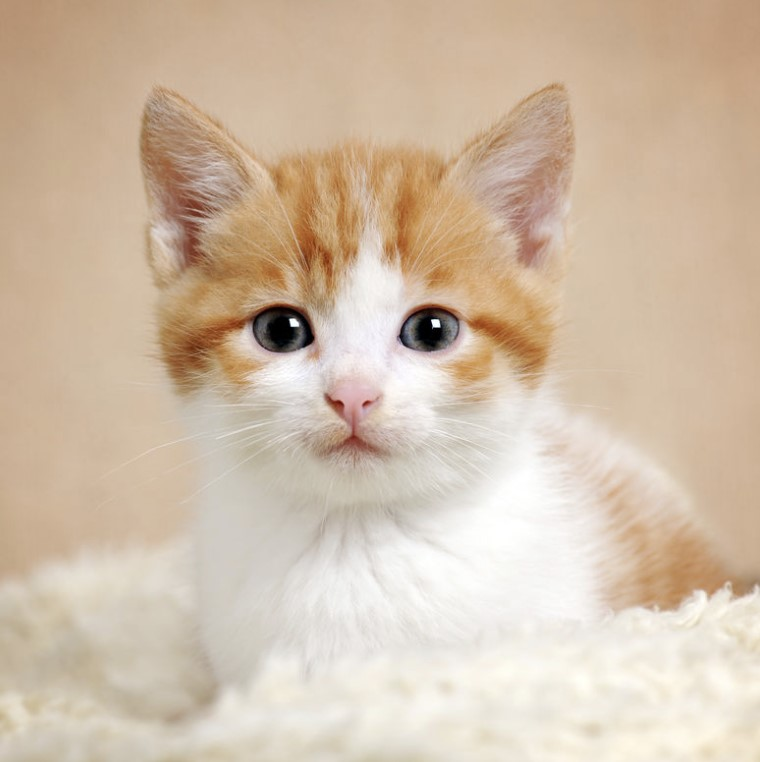

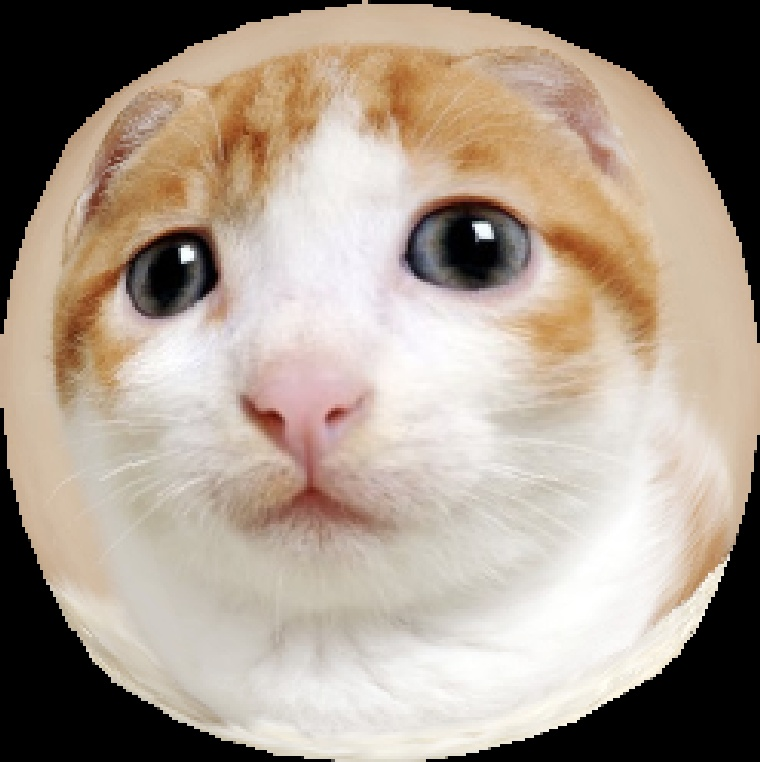

In [15]:
from IPython.display import Image, display

# 输入图像的路径
input_image_path = 'input.jpg'

# 输出图像的路径
output_image_path = 'output.jpg'

# 显示输入图像
display(Image(filename=input_image_path))

# 显示输出图像
display(Image(filename=output_image_path))